# DRL-05: Creating Your Own Environment

In this lab, we will learn how to create our own environment games, snake and connect4.

## Check gym environment characteristics

Let's see a Gym environment, SpaceInvaders.

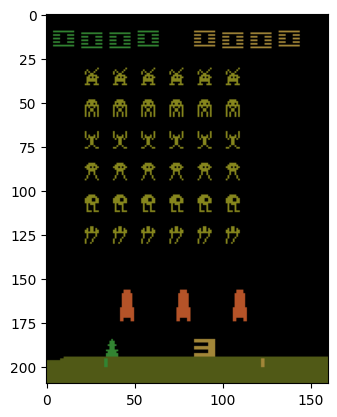

In [6]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()
# create environment

env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')

# reset environments
obs, info = env.reset()

prev_screen = env.render()
plt.imshow(prev_screen)

for i in range(5):
  action = env.action_space.sample()
  obs, reward, done, truncated, info = env.step(action)
  screen = env.render()

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()

### Important methods

All gym environments have the same methods:
- Create environment
- Reset: roll back all data into initial data.
- action_space: get number of actions and all possible actions which can be input.
- legal_action: The action which current state can do.
- State: the state which agent can observe
- Step: Funcion which recieve an input and compe out the next state.
- Reward
- Render: Visual effect function

Thus, we should create an environment which support the methods as above.

### abstract environment

Abstract environment is the class which start for all environment. It contains all important functions. If we create only one environment, we may not need to use it.

In visual studio code, create a folder **Games** and create a python file named **abstract_game.py**. Put the abstract code into the file at below.

For google colab, you just copy the code into the cell.

<img src="img/lab03abstractgame.png" title="abstract_game" style="width: 800px;" />

In [1]:
from abc import ABC, abstractmethod


class AbstractGame(ABC):
    """
    Inherit this class for muzero to play
    """

    @abstractmethod
    def __init__(self, seed=None):
        pass

    @abstractmethod
    def step(self, action):
        """
        Apply action to the game.
        
        Args:
            action : action of the action_space to take.

        Returns:
            The new observation, the reward and a boolean if the game has ended.
        """
        pass

    def to_play(self):
        """
        Return the current player.

        Returns:
            The current player, it should be an element of the players list in the config. 
        """
        return 0

    @abstractmethod
    def legal_actions(self):
        """
        Should return the legal actions at each turn, if it is not available, it can return
        the whole action space. At each turn, the game have to be able to handle one of returned actions.
        
        For complex game where calculating legal moves is too long, the idea is to define the legal actions
        equal to the action space but to return a negative reward if the action is illegal.

        Returns:
            An array of integers, subset of the action space.
        """
        pass

    @abstractmethod
    def reset(self):
        """
        Reset the game for a new game.
        
        Returns:
            Initial observation of the game.
        """
        pass

    def close(self):
        """
        Properly close the game.
        """
        pass

    @abstractmethod
    def render(self):
        """
        Display the game observation.
        """
        pass

    def human_to_action(self):
        """
        For multiplayer games, ask the user for a legal action
        and return the corresponding action number.

        Returns:
            An integer from the action space.
        """
        choice = input(f"Enter the action to play for the player {self.to_play()}: ")
        while int(choice) not in self.legal_actions():
            choice = input("Ilegal action. Enter another action : ")
        return int(choice)

    def expert_agent(self):
        """
        Hard coded agent that faces to assess his progress in multiplayer games.
        It doesn't influence training

        Returns:
            Action as an integer to take in the current game state
        """
        raise NotImplementedError

    def action_to_string(self, action_number):
        """
        Convert an action number to a string representing the action.

        Args:
            action_number: an integer from the action space.

        Returns:
            String representing the action.
        """
        return str(action_number)

### Let's start to Connect4

We first start to connect4 because there is no graphic support. It is easier to make it in terminal or by print() function. The connect4 is a game which plays with two players play in 2 colors. The board size is $6\times 7$. To win the game, a player must put the same color stone connect together up to 4 stones in vertical, horizontal, or diagonal line.

<img src="img/connect4.jpg" title="connect4" style="width: 600px;" />

### Connect4 file

Create another file name connect4.py in the **Games** folder. Create a **Game** class and inherit **AbstractGame** class.

The methods which be fill as initial condition are:
- **__init__** method: create environment of the game such as board data, and player turn.
- **to_play** method: return the current player.
- **reset** method: reset board and player turn.

In [ ]:
import os
import numpy

from .abstract_game import AbstractGame

class Game(AbstractGame):
    """
    Game wrapper.
    """
    def __init__(self, seed=None):
        self.p0 = 1
        self.p1 = -1
        self.board_size = (6, 7)
        # board size, 6 rows and 7 columns
        self.board = numpy.zeros(self.board_size, dtype="int32")
        self.player = self.p0     ## player O as 1 and player X as -1

    def to_play(self):
        """
        Return the current player.

        Returns:
            The current player, it should be an element of the players list in the config. 
        """
        return self.player

    def reset(self):
        """
        Reset the game for a new game.
        
        Returns:
            Initial observation of the game.
        """
        self.board = numpy.zeros(self.board_size, dtype="int32")
        self.player = self.p0     ## player O as 1 and player X as -1
        return self.get_observation()


#### For Colab user

Remove <code>from .abstract_game import AbstractGame</code> line

## get_observation() method

The method release the current state of the game. it is up to user which want to get the game observation structure for training. As normal observation structure for 2 players, it is mostly used as 3 tensors for an observation state.
- Player1 played in the board
- Player2 played in the board
- Current player which needs to play

In [ ]:
    def get_observation(self):
        board_player1 = numpy.where(self.board == self.p0, 1, 0)
        board_player2 = numpy.where(self.board == self.p1, 1, 0)
        board_to_play = numpy.full(self.board_size, self.player)
        return numpy.array([board_player1, board_player2, board_to_play], dtype="int32")

## legal_actions() method

When playing the game, there are some move that players cannot play. The method needs for check where players cannot play.

In [ ]:
    def legal_actions(self):
        '''
            We check only the top of the board.
            If the board is full, the top of board will have a stone.
        '''
        legal = []
        counter = 0
        for i in range(self.board_size[1]):
            if self.board[0, i] == 0:
                legal.append(i)
        return legal

## step() method
The step method lets agent or user input the next action into the board. the method needs to update a new observation state and check whether the game is finished, and calculates the reward.

The reward for board such as tic-tac-toe, connect4, chess will have conditions like:
- The game is not finished: No reward (normally 0)
- The game is finished: Win, draw, lose (normally $[1, 0, -1]$)

Note: **have_winner** method must be used in the method, we will take a look later.

In [ ]:
    def step(self, action):
        # action is a number 0-6 for declare column of position in the board


        # Check that the action is illegal action, unless the player should loss from illegal action.
        if not (action in self.legal_actions()):
            return self.get_observation(), -1, True

        # input the action of current player into the board
        for i in range(self.board_size[0]):
            # first start at the 
            row = self.board_size[0] - 1
            if self.board[row, action] != 0:
                continue
            else:
                self.board[row, action] = self.player

        # Check that the game is finished in 2 condition: have a winner, or no any moves left
        have_win = self.have_winner()
        done = have_win or len(self.legal_actions()) == 0

        # If have the winner, the current player should be a winner.
        reward = 1 if have_win else 0

        # change current player
        self.player *= -1

        return self.get_observation(), reward, done

## have_winner() method

This method is used for check the game has winner. In connect4, it can win when there are same 4 marks in the same horizontal or vertical, or diagonal.

In [ ]:
    def have_winner(self):
        # Horizontal check
        for i in range(self.board[1] - 3):
            for j in range(self.board[0]):
                if (
                    self.board[j][i] == self.player
                    and self.board[j][i + 1] == self.player
                    and self.board[j][i + 2] == self.player
                    and self.board[j][i + 3] == self.player
                ):
                    return True

        # Vertical check
        for i in range(self.board[1]):
            for j in range(self.board[0] - 3):
                if (
                    self.board[j][i] == self.player
                    and self.board[j + 1][i] == self.player
                    and self.board[j + 2][i] == self.player
                    and self.board[j + 3][i] == self.player
                ):
                    return True

        # Positive diagonal check
        for i in range(self.board[1] - 3):
            for j in range(self.board[0] - 3):
                if (
                    self.board[j][i] == self.player
                    and self.board[j + 1][i + 1] == self.player
                    and self.board[j + 2][i + 2] == self.player
                    and self.board[j + 3][i + 3] == self.player
                ):
                    return True

        # Negative diagonal check
        for i in range(self.board[1] - 3):
            for j in range(self.board[0] - 3, self.board[0]):
                if (
                    self.board[j][i] == self.player
                    and self.board[j - 1][i + 1] == self.player
                    and self.board[j - 2][i + 2] == self.player
                    and self.board[j - 3][i + 3] == self.player
                ):
                    return True

        return False

## Prototype is done

Ok, now you have your prototype simulator which the code should be look liked this.

**Note**: Do not forget to add the other functions which already in AbstractGame class

In [6]:
import os
import numpy

from .abstract_game import AbstractGame

class Game(AbstractGame):
    """
    Game wrapper.
    """
    def __init__(self, seed=None):
        self.p0 = 1
        self.p1 = -1
        self.board_size = (6, 7)
        # board size, 6 rows and 7 columns
        self.board = numpy.zeros(self.board_size, dtype="int32")
        self.player = self.p0     ## player O as 1 and player X as -1

    def to_play(self):
        """
        Return the current player.

        Returns:
            The current player, it should be an element of the players list in the config. 
        """
        return self.player

    def reset(self):
        """
        Reset the game for a new game.
        
        Returns:
            Initial observation of the game.
        """
        self.board = numpy.zeros(self.board_size, dtype="int32")
        self.player = self.p0     ## player O as 1 and player X as -1
        return self.get_observation()

    def get_observation(self):
        board_player1 = numpy.where(self.board == self.p0, 1, 0)
        board_player2 = numpy.where(self.board == self.p1, 1, 0)
        board_to_play = numpy.full(self.board_size, self.player)
        return numpy.array([board_player1, board_player2, board_to_play], dtype="int32")

    def legal_actions(self):
        '''
            We check only the top of the board.
            If the board is full, the top of board will have a stone.
        '''
        legal = []
        counter = 0
        for i in range(self.board_size[1]):
            if self.board[0, i] == 0:
                legal.append(i)
        return legal

    def step(self, action):
        # action is a number 0-6 for declare column of position in the board


        # Check that the action is illegal action, unless the player should loss from illegal action.
        if not (action in self.legal_actions()):
            return self.get_observation(), -1, True

        # input the action of current player into the board
        for i in range(self.board_size[0]):
            # first start at the 
            row = self.board_size[0] - i - 1
            if self.board[row, action] == 0:
                self.board[row, action] = self.player
                break

        # Check that the game is finished in 2 condition: have a winner, or no any moves left
        have_win = self.have_winner()
        done = have_win or len(self.legal_actions()) == 0

        # If have the winner, the current player should be a winner.
        reward = 1 if have_win else 0

        # change current player
        self.player *= -1

        return self.get_observation(), reward, done

    def have_winner(self):
        # Horizontal check
        for i in range(self.board_size[1] - 3):
            for j in range(self.board_size[0]):
                if (
                    self.board[j][i] == self.player
                    and self.board[j][i + 1] == self.player
                    and self.board[j][i + 2] == self.player
                    and self.board[j][i + 3] == self.player
                ):
                    return True

        # Vertical check
        for i in range(self.board_size[1]):
            for j in range(self.board_size[0] - 3):
                if (
                    self.board[j][i] == self.player
                    and self.board[j + 1][i] == self.player
                    and self.board[j + 2][i] == self.player
                    and self.board[j + 3][i] == self.player
                ):
                    return True

        # Positive diagonal check
        for i in range(self.board_size[1] - 3):
            for j in range(self.board_size[0] - 3):
                if (
                    self.board[j][i] == self.player
                    and self.board[j + 1][i + 1] == self.player
                    and self.board[j + 2][i + 2] == self.player
                    and self.board[j + 3][i + 3] == self.player
                ):
                    return True

        # Negative diagonal check
        for i in range(self.board_size[1] - 3):
            for j in range(self.board_size[0] - 3, self.board_size[0]):
                if (
                    self.board[j][i] == self.player
                    and self.board[j - 1][i + 1] == self.player
                    and self.board[j - 2][i + 2] == self.player
                    and self.board[j - 3][i + 3] == self.player
                ):
                    return True

        return False

    def render(self):
        pass

    def human_to_action(self):
        pass

    def expert_agent(self):
        pass

    def action_to_string(self, action_number):
        pass

### Try to run the simulator

At the outside **Games** folder, create a **main.py** file

In [ ]:
import Games
import importlib

game_name = 'connect4'
game_module = importlib.import_module("Games." + game_name)
env = game_module.Game()

env.reset()

#### For colab user

Change the class name from **Game** to be **Connect4** use the code as below.

In [7]:
env = Connect4()

env.reset()

array([[[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]],

       [[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1]]], dtype=int32)

Try to input some stones into the game and take a look the output.

In [8]:
env.reset()

next_state, reward, done = env.step(4)
print(next_state, 'reward', reward, 'is_done:', done)

next_state, reward, done = env.step(4)
print(next_state, 'reward', reward, 'is_done:', done)

next_state, reward, done = env.step(1)
print(next_state, 'reward', reward, 'is_done:', done)

next_state, reward, done = env.step(0)
print(next_state, 'reward', reward, 'is_done:', done)

[[[ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  1  0  0]]

 [[ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]]

 [[-1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1 -1]]] reward 0 is_done: False
[[[0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0]
  [0 0 0 0 0 0 0]]

 [[1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1]]] reward 0 is_done: False
[[[ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0]
  [ 0  1  0  0  1  0  0]]

 [[ 0  0  0  0

You can see the player0's stones are in the first array block of column 1 and 4 (start index at 0) and player1's stones are in the second array block. The last array block say about the next player (1 is player 0 and -1 is player 1)

### Render() method

Because the state observation is for agent input, it is difficult to observe by human's eye. We need to create render() method for graphical view. It is not necessay for agent, so we do not need to do it. 

In [ ]:
    def render(self):
        for i in range(self.board_size[0] * 2 - 1):
            row = int(i/2)
            str = ""
            for j in range(self.board_size[1] * 4 - 1):
                col = int(j / 4)
                if i == row * 2 + 1 and j == col * 4 + 3:
                    str += "+"
                elif i == row * 2 and j == col * 4 + 1:
                    if self.board[row,col] == 1:
                        str += "O"
                    elif self.board[row,col] == -1:
                        str += "X"
                    else:
                        str += " "
                elif i == row * 2 + 1:
                    str += "-"
                elif j == col * 4 + 3:
                    str += "|"
                
                else:
                    str += " "
            print(str)

In [ ]:
env.reset()
env.render()
print("Next player: ", env.player)
next_state, reward, done = env.step(4)
env.render()
print("Next player: ", env.player)
next_state, reward, done = env.step(5)
env.render()
print("Next player: ", env.player)
next_state, reward, done = env.step(1)
env.render()
print("Next player: ", env.player)
next_state, reward, done = env.step(0)
env.render()
print("Next player: ", env.player)

### Fill other important methods

- action_to_string: let environment explain the current action
- human_to_action: use the function for making environment interact with human

In [ ]:
    def action_to_string(self, action_number):
        if self.player == self.p0:
            py = "O"
        else:
            py = "X"
        return f"Player {py} Play column {action_number}"

    def human_to_action(self):
        if self.player == self.p0:
            py = "O"
        else:
            py = "X"
        while True:
            try:
                print(f"Player: {py} turn")
                col = int(
                    input(
                        f"Enter the column (1, 2, 3, 4, 5 or 6) to play for the player {self.to_play()}: "
                    )
                )
                choice = col - 1
                if (
                    choice in self.legal_actions()
                ):
                    break
            except:
                pass
            print("Wrong input, try again")
        return choice

### The Full code is below

In [14]:
import os
import numpy

from .abstract_game import AbstractGame

class Game(AbstractGame):
    """
    Game wrapper.
    """
    def __init__(self, seed=None):
        self.p0 = 1
        self.p1 = -1
        self.board_size = (6, 7)
        # board size, 6 rows and 7 columns
        self.board = numpy.zeros(self.board_size, dtype="int32")
        self.player = self.p0     ## player O as 1 and player X as -1

    def to_play(self):
        """
        Return the current player.

        Returns:
            The current player, it should be an element of the players list in the config. 
        """
        return self.player

    def reset(self):
        """
        Reset the game for a new game.
        
        Returns:
            Initial observation of the game.
        """
        self.board = numpy.zeros(self.board_size, dtype="int32")
        self.player = self.p0     ## player O as 1 and player X as -1
        return self.get_observation()

    def get_observation(self):
        board_player1 = numpy.where(self.board == self.p0, 1, 0)
        board_player2 = numpy.where(self.board == self.p1, 1, 0)
        board_to_play = numpy.full(self.board_size, self.player)
        return numpy.array([board_player1, board_player2, board_to_play], dtype="int32")

    def legal_actions(self):
        '''
            We check only the top of the board.
            If the board is full, the top of board will have a stone.
        '''
        legal = []
        counter = 0
        for i in range(self.board_size[1]):
            if self.board[0, i] == 0:
                legal.append(i)
        return legal

    def step(self, action):
        # action is a number 0-6 for declare column of position in the board


        # Check that the action is illegal action, unless the player should loss from illegal action.
        if not (action in self.legal_actions()):
            return self.get_observation(), -1, True

        # input the action of current player into the board
        for i in range(self.board_size[0]):
            # first start at the 
            row = self.board_size[0] - i - 1
            if self.board[row, action] == 0:
                self.board[row, action] = self.player
                break

        # Check that the game is finished in 2 condition: have a winner, or no any moves left
        have_win = self.have_winner()
        done = have_win or len(self.legal_actions()) == 0

        # If have the winner, the current player should be a winner.
        reward = 1 if have_win else 0

        # change current player
        self.player *= -1

        return self.get_observation(), reward, done

    def have_winner(self):
        # Horizontal check
        for i in range(self.board_size[1] - 3):
            for j in range(self.board_size[0]):
                if (
                    self.board[j][i] == self.player
                    and self.board[j][i + 1] == self.player
                    and self.board[j][i + 2] == self.player
                    and self.board[j][i + 3] == self.player
                ):
                    return True

        # Vertical check
        for i in range(self.board_size[1]):
            for j in range(self.board_size[0] - 3):
                if (
                    self.board[j][i] == self.player
                    and self.board[j + 1][i] == self.player
                    and self.board[j + 2][i] == self.player
                    and self.board[j + 3][i] == self.player
                ):
                    return True

        # Positive diagonal check
        for i in range(self.board_size[1] - 3):
            for j in range(self.board_size[0] - 3):
                if (
                    self.board[j][i] == self.player
                    and self.board[j + 1][i + 1] == self.player
                    and self.board[j + 2][i + 2] == self.player
                    and self.board[j + 3][i + 3] == self.player
                ):
                    return True

        # Negative diagonal check
        for i in range(self.board_size[1] - 3):
            for j in range(self.board_size[0] - 3, self.board_size[0]):
                if (
                    self.board[j][i] == self.player
                    and self.board[j - 1][i + 1] == self.player
                    and self.board[j - 2][i + 2] == self.player
                    and self.board[j - 3][i + 3] == self.player
                ):
                    return True

        return False

    def render(self):
        for i in range(self.board_size[0] * 2 - 1):
            row = int(i/2)
            str = ""
            for j in range(self.board_size[1] * 4 - 1):
                col = int(j / 4)
                if i == row * 2 + 1 and j == col * 4 + 3:
                    str += "+"
                elif i == row * 2 and j == col * 4 + 1:
                    if self.board[row,col] == 1:
                        str += "O"
                    elif self.board[row,col] == -1:
                        str += "X"
                    else:
                        str += " "
                elif i == row * 2 + 1:
                    str += "-"
                elif j == col * 4 + 3:
                    str += "|"
                
                else:
                    str += " "
            print(str)

    def expert_agent(self):
        """
        Hard coded agent that MuZero faces to assess his progress in multiplayer games.
        It doesn't influence training

        Returns:
            Action as an integer to take in the current game state
        """
        pass

    def action_to_string(self, action_number):
        if self.player == self.p0:
            py = "O"
        else:
            py = "X"
        return f"Player {py} Play column {action_number}"

    def human_to_action(self):
        if self.player == self.p0:
            py = "O"
        else:
            py = "X"
        while True:
            try:
                print(f"Player: {py} turn")
                col = int(
                    input(
                        f"Enter the column (1, 2, 3, 4, 5 or 6) to play for the player {self.to_play()}: "
                    )
                )
                choice = col - 1
                if (
                    choice in self.legal_actions()
                ):
                    break
            except:
                pass
            print("Wrong input, try again")
        return choice

## Try your simulator

Make sure that your simulator does not have any problems.

In [ ]:
game_name = 'connect4'
game_module = importlib.import_module("Games." + game_name)
env = game_module.Game()

env.reset()
env.render()
print("Next player: ", env.player)
is_done = False

while not is_done:
    action = env.human_to_action()
    print(chr(27) + "[2J")        # clear screen
    env.action_to_string(action)
    next_state, reward, is_done = env.step(action)
    env.render()
    print("Next player: ", env.player)
    
print("The game finish, winner is: ", (env.player * -1))

For colab and jupyter users

In [15]:
from IPython import display as ipythondisplay

env = Connect4()

env.reset()
env.render()
print("Next player: ", env.player)
is_done = False

while not is_done:
    action = env.human_to_action()
    ipythondisplay.clear_output(wait=True)
    env.action_to_string(action)
    next_state, reward, is_done = env.step(action)
    env.render()
    print("Next player: ", env.player)
    
print("The game finish, winner is: ", (env.player * -1))

   |   |   |   |   |   |   
---+---+---+---+---+---+---
   |   |   |   |   |   |   
---+---+---+---+---+---+---
 O |   |   |   |   |   |   
---+---+---+---+---+---+---
 O | X |   |   |   |   |   
---+---+---+---+---+---+---
 O | X |   |   |   |   |   
---+---+---+---+---+---+---
 O | X |   |   |   |   |   
Next player:  -1
The game finish, winner is:  1


You can see the Colab code from the [link](https://colab.research.google.com/drive/1VkfLsPJvfQYvJ8GklbtiuptZsuD-na3_?usp=sharing)

## Snake game

Snake is a video game genre where the player maneuvers a growing line that becomes a primary obstacle to itself.

In the lab, we are going to create snake game using a graphic library: pygame. This is the concept which apply some graphic library to make your own environment.

<img src="img/Snake_can_be_completed.gif" title="snake" style="width: 400px;" />

### Pygame

PyGame is a library of python language. It is used to develop 2-D games and is a platform where you can set python modules to develop a game. It is a user-friendly platform that helps to build games quickly and easily.

All OS can use the same command.

In [16]:
!pip install pygame

     |████████████████████████████████| 21.8 MB 1.7 MB/s eta 0:00:01


### The basically code of snake game

We use the source code from the [link](https://www.edureka.co/blog/snake-game-with-pygame/), and apply it into our environment code for reinforcement learning.

The code below cannot be used in google colab, but in visual studio code and jupyter is ok.

In [17]:
import pygame
import time
import random
 
pygame.init()
 
white = (255, 255, 255)
yellow = (255, 255, 102)
black = (0, 0, 0)
red = (213, 50, 80)
green = (0, 255, 0)
blue = (50, 153, 213)
 
dis_width = 600
dis_height = 400
 
dis = pygame.display.set_mode((dis_width, dis_height))
pygame.display.set_caption('Snake Game by Edureka')
 
clock = pygame.time.Clock()
 
snake_block = 10
snake_speed = 15
 
font_style = pygame.font.SysFont("bahnschrift", 25)
score_font = pygame.font.SysFont("comicsansms", 35)
 
 
def Your_score(score):
    value = score_font.render("Your Score: " + str(score), True, yellow)
    dis.blit(value, [0, 0])
 
 
 
def our_snake(snake_block, snake_list):
    for x in snake_list:
        pygame.draw.rect(dis, black, [x[0], x[1], snake_block, snake_block])
 
 
def message(msg, color):
    mesg = font_style.render(msg, True, color)
    dis.blit(mesg, [dis_width / 6, dis_height / 3])
 
 
def gameLoop():
    game_over = False
    game_close = False
 
    x1 = dis_width / 2
    y1 = dis_height / 2
 
    x1_change = 0
    y1_change = 0
 
    snake_List = []
    Length_of_snake = 1
 
    foodx = round(random.randrange(0, dis_width - snake_block) / 10.0) * 10.0
    foody = round(random.randrange(0, dis_height - snake_block) / 10.0) * 10.0
 
    while not game_over:
 
        while game_close == True:
            dis.fill(blue)
            message("You Lost! Press C-Play Again or Q-Quit", red)
            Your_score(Length_of_snake - 1)
            pygame.display.update()
 
            for event in pygame.event.get():
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_q:
                        game_over = True
                        game_close = False
                    if event.key == pygame.K_c:
                        gameLoop()
 
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                game_over = True
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_LEFT:
                    x1_change = -snake_block
                    y1_change = 0
                elif event.key == pygame.K_RIGHT:
                    x1_change = snake_block
                    y1_change = 0
                elif event.key == pygame.K_UP:
                    y1_change = -snake_block
                    x1_change = 0
                elif event.key == pygame.K_DOWN:
                    y1_change = snake_block
                    x1_change = 0
 
        if x1 >= dis_width or x1 < 0 or y1 >= dis_height or y1 < 0:
            game_close = True
        x1 += x1_change
        y1 += y1_change
        dis.fill(blue)
        pygame.draw.rect(dis, green, [foodx, foody, snake_block, snake_block])
        snake_Head = []
        snake_Head.append(x1)
        snake_Head.append(y1)
        snake_List.append(snake_Head)
        if len(snake_List) > Length_of_snake:
            del snake_List[0]
 
        for x in snake_List[:-1]:
            if x == snake_Head:
                game_close = True
 
        our_snake(snake_block, snake_List)
        Your_score(Length_of_snake - 1)
 
        pygame.display.update()
 
        if x1 == foodx and y1 == foody:
            foodx = round(random.randrange(0, dis_width - snake_block) / 10.0) * 10.0
            foody = round(random.randrange(0, dis_height - snake_block) / 10.0) * 10.0
            Length_of_snake += 1
 
        clock.tick(snake_speed)
 
    pygame.quit()
    quit()
 
 
gameLoop()

pygame 2.1.2 (SDL 2.0.16, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Modification

We need to remove the **score** in the screen, and modify **event** to be an action. Moreover, to let the system can be shown in pyplot (for colab), we need to add some code for support it.

### State observation

For the state observation, we adapt the observation as the easiest way (it is not good, but use for sample).
- Snake Position $[x,y]$
- Snake head direction $[top, right, down, left]$
- Obstacle direction in 1 block area $[top, right, down, left]$
- Snack direction $[top, right, down, left]$

In [ ]:
import os
import numpy
import pygame
import random

from .abstract_game import AbstractGame

class Game(AbstractGame):
    """
    Game wrapper.
    """
    def __init__(self, use_imshow = False):
        if use_imshow:
            os.environ["SDL_VIDEODRIVER"] = "dummy"

        self.player = 1
        pygame.init()

        self.white = (255, 255, 255)
        self.yellow = (255, 255, 102)
        self.black = (0, 0, 0)
        self.red = (213, 50, 80)
        self.green = (0, 255, 0)
        self.blue = (50, 153, 213)

        self.dis_width = 600
        self.dis_height = 400

        self.dis = pygame.display.set_mode((self.dis_width, self.dis_height))

        self.snake_block = 10
        
        self.reset()

    def to_play(self):
        """
        Return the current player.

        Returns:
            The current player, it should be an element of the players list in the config. 
        """
        return self.player

    def reset(self):
        """
        Reset the game for a new game.
        
        Returns:
            Initial observation of the game.
        """
        self.game_over = False

        self.x1 = self.dis_width / 2
        self.y1 = self.dis_height / 2

        self.x1_change = 0
        self.y1_change = 0

        self.snake_List = []
        snake_Head = []
        snake_Head.append(self.x1)
        snake_Head.append(self.y1)
        self.snake_List.append(snake_Head)
        self.Length_of_snake = 1

        self.foodx = round(random.randrange(0, self.dis_width - self.snake_block) / 10.0) * 10.0
        self.foody = round(random.randrange(0, self.dis_height - self.snake_block) / 10.0) * 10.0
        return self.get_observation()
    
    def is_game_over(self):
        '''
        Check game over
        '''
        if (self.x1 + self.snake_block >= self.dis_width or self.x1 < 0 or
                self.y1 + self.snake_block >= self.dis_height or self.y1 < 0):
            self.game_over = True
            
        snake_Head = []
        snake_Head.append(self.x1)
        snake_Head.append(self.y1)
        for x in self.snake_List[:-1]:
            if x == snake_Head:
                self.game_over = True
        return self.game_over

    def get_observation(self):
        # check head direction
        direction = [0,0,0,0]
        if self.x1_change < 0:
            direction[3] = 1
        if self.x1_change > 0:
            direction[1] = 1
        if self.y1_change < 0:
            direction[0] = 1
        if self.y1_change > 0:
            direction[2] = 1
            
        # check obstacle
        obstacle = [0,0,0,0]
        if self.x1 - 1 < 0:
            obstacle[3] = 1
        if self.x1 + self.snake_block + 1 > self.dis_width:
            obstacle[1] = 1
        if self.y1 - 1 < 0:
            obstacle[0] = 1
        if self.y1 + self.snake_block + 1 > self.dis_height:
            obstacle[2] = 1
            
        snake_Head = []
        snake_Head.append(self.x1)
        snake_Head.append(self.y1)
        for x in self.snake_List[:-1]:
            if x[0] == snake_Head[0] and x[1] == snake_Head[1] - 1:
                obstacle[0] = 1
            elif x[0] == snake_Head[0] and x[1] == snake_Head[1] + 1:
                obstacle[2] = 1
            elif x[0] - 1 == snake_Head[0] and x[1] == snake_Head[1]:
                obstacle[1] = 1
            elif x[0] + 1 == snake_Head[0] and x[1] == snake_Head[1]:
                obstacle[3] = 1
                
        # Check snack
        snack = [0,0,0,0]
        if self.foodx < self.x1:
            snack[3] = 1
        elif self.foodx > self.x1:
            snack[1] = 1
        if self.foody < self.y1:
            snack[0] = 1
        elif self.foody > self.y1:
            snack[2] = 1
            
        return [self.x1, self.y1, direction[0], direction[1], direction[2], direction[3],
                obstacle[0], obstacle[1], obstacle[2], obstacle[3],
                snack[0], snack[1], snack[2], snack[3]]
    
    def legal_actions(self):
        '''
        Snake can move in 4 direction no matter what.
        '''
        return [0, 1, 2, 3]
    
    def step(self, action):
        if action == 0:
            self.x1_change = 0
            self.y1_change = -self.snake_block
        elif action == 1:
            self.x1_change = self.snake_block
            self.y1_change = 0
        elif action == 2:
            self.x1_change = 0
            self.y1_change = self.snake_block
        elif action == 3:
            self.x1_change = -self.snake_block
            self.y1_change = 0
            
        self.x1 += self.x1_change
        self.y1 += self.y1_change
        
        snake_Head = []
        snake_Head.append(self.x1)
        snake_Head.append(self.y1)
        self.snake_List.append(snake_Head)
        if len(self.snake_List) > self.Length_of_snake:
            del self.snake_List[0]
            
        if self.x1 == self.foodx and self.y1 == self.foody:
            self.foodx = round(random.randrange(0, self.dis_width - self.snake_block) / 10.0) * 10.0
            self.foody = round(random.randrange(0, self.dis_height - self.snake_block) / 10.0) * 10.0
            self.Length_of_snake += 1
            
        return self.get_observation(), self.Length_of_snake, self.is_game_over()
        
    def draw_snake(self, snake_block, snake_list):
        for x in snake_list:
            pygame.draw.rect(self.dis, self.green, [x[0], x[1], self.snake_block, self.snake_block])
    
    def render(self):
        # draw background
        self.dis.fill(self.black)
        # draw snake
        self.draw_snake(self.snake_block, self.snake_List)
        # draw food
        pygame.draw.rect(self.dis, self.blue, [self.foodx, self.foody, self.snake_block, self.snake_block])
        pygame.display.update()
        image = pygame.surfarray.array3d(self.dis)
        image = image.transpose([1, 0, 2])
        return image
    
    def quit(self):
        pygame.quit()

    def human_to_action(self):
        while True:
            try:
                col = int(
                    input(
                        f"Enter the column (1, 2, 3, or 4) to let snake move: "
                    )
                )
                choice = col - 1
                if (
                    choice in self.legal_actions()
                ):
                    break
            except:
                pass
            print("Wrong input, try again")
        return choice

### Testing in Visual studio code

In [ ]:
import Games
import importlib
import time
import matplotlib.pyplot as plt

game_name = 'snake'
game_module = importlib.import_module("Games." + game_name)
env = game_module.Game()
next_state = env.reset()
image = env.render()
print("state observation: ", next_state)

for i in range(25):
    action = env.human_to_action()
    next_state, reward, is_done = env.step(action)
    image = env.render()
    print("state observation: ", next_state)
#time.sleep(5)
env.quit()
quit()

### Testing in Colab

In [ ]:
import time
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

env = Snake(use_imshow=True)
next_state = env.reset()
image = env.render()
plt.imshow(image)
ipythondisplay.clear_output(wait=True)
ipythondisplay.display(plt.gcf())
print("state observation: ", next_state)

for i in range(25):
    action = env.human_to_action()
    next_state, reward, is_done = env.step(action)
    if is_done:
      print("Game over")
      break
    image = env.render()
    plt.imshow(image)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    print("state observation: ", next_state)
env.quit()

The colab code example is in the [link](https://colab.research.google.com/drive/1JfDJQE7dysUhdhgBVU9YSsLdz2dWV3_A?usp=sharing)

### Lab 05 exercise

Do an environment using any **graphic library** as you like (OpenCV, OpenGL, PyGame, or others). The environment must support agent actions input in fix action. The environment game example:
- Pong game
- Car racing
- Tetris
- Car driving
- Robot in the maze